Text Processing and Cleaning
* Combining statements from Edgar and Nitin
* removing stopwords, special characters
* removing company name from the statement - compant name in the statement is not relevant for textual analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import concurrent.futures
from tqdm import tqdm
from typing import Optional, List, Dict, Callable
from urlextract import URLExtract
import nltk
import re
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

from collections import Counter
from copy import deepcopy
from typing import Dict, Tuple

In [3]:
from modern_slavery import get_root_path
from modern_slavery.text_parser_v2 import (
    word_expantions, 
    find_urls_in_text, 
    CustomWordNetLemmatizer)

In [4]:
DATA_PATH = os.path.join(get_root_path(), "data")
SHEETS_PATH = os.path.join(DATA_PATH,  "sheets")

In [5]:
df = pd.read_csv(
    os.path.join(SHEETS_PATH, "modern_slavery_dataset.csv"))

print(f"Number of rows before removing rows with NULL statements: {len(df)}")
df.dropna(subset=["Text"], inplace=True, axis=0)
print(f"Number of rows after removing rows with NULL statements: {len(df)}")

print(f"Number of rows before removing duplicate rows: {len(df)}")
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Number of rows after removing duplicate rows: {len(df)}")

df["Text"] = df["Text"].astype(str)
df.head()

Number of rows before removing rows with NULL statements: 28417
Number of rows after removing rows with NULL statements: 18622
Number of rows before removing duplicate rows: 18622
Number of rows after removing duplicate rows: 18621


,Company ID,Company,Is Publisher,Statement ID,URL,Override URL,Companies House Number,Industry,HQ,Is Also Covered,UK Modern Slavery Act,California Transparency in Supply Chains Act,Australia Modern Slavery Act,Period Covered,Text
0,7676,"""K"" Line Holding Europe Limited",True,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,05005018,Marine,United Kingdom,False,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
1,28660,"""K"" Line Bulk Shipping (UK) Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,04830352,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
2,28659,"""K"" Line (Europe) Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,05639474,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
3,28661,"""K"" Line LNG Shipping Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,NaN,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
4,28658,Polar LNG Shipping (UK) Limited,False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,02205323,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...


## Getting level of data

In [6]:
df.nunique(axis=0)

Company ID                                      13207
Company                                         13207
Is Publisher                                        2
Statement ID                                    12181
URL                                             10827
Override URL                                        3
Companies House Number                          10367
Industry                                           71
HQ                                                 64
Is Also Covered                                     2
UK Modern Slavery Act                               2
California Transparency in Supply Chains Act        2
Australia Modern Slavery Act                        2
Period Covered                                     17
Text                                            10025
dtype: int64

In [7]:
print(f"Number of rows: {len(df)}")
cols = ["Company ID", "Company", "Statement ID", "URL"]
for i in range(1, len(cols)+1):
    print(f'Unique entries across cols {cols[:i]}: {len(df.drop_duplicates(cols[:i]))}')

Number of rows: 18621
Unique entries across cols ['Company ID']: 13207
Unique entries across cols ['Company ID', 'Company']: 13207
Unique entries across cols ['Company ID', 'Company', 'Statement ID']: 18621
Unique entries across cols ['Company ID', 'Company', 'Statement ID', 'URL']: 18621


In [10]:
len(df.drop_duplicates(["Company ID", "Statement ID"]))

18621

### <font color="blue">Level of data = ["Company ID", "Statement ID"]</font>

## Adding `Row ID` as unique identifier of each row

In [8]:
df.insert(loc=0, column='Row ID', value=df.index, allow_duplicates=False)
df.head()

,Row ID,Company ID,Company,Is Publisher,Statement ID,URL,Override URL,Companies House Number,Industry,HQ,Is Also Covered,UK Modern Slavery Act,California Transparency in Supply Chains Act,Australia Modern Slavery Act,Period Covered,Text
0,0,7676,"""K"" Line Holding Europe Limited",True,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,05005018,Marine,United Kingdom,False,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
1,1,28660,"""K"" Line Bulk Shipping (UK) Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,04830352,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
2,2,28659,"""K"" Line (Europe) Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,05639474,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
3,3,28661,"""K"" Line LNG Shipping Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,NaN,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
4,4,28658,Polar LNG Shipping (UK) Limited,False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,02205323,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...


# Text Cleaning

In [22]:
%%time
# mss: modern_slavery_statement
def is_mss(statement: str) -> bool:
    """Classify whether given statement is modern slavery statement or not."""
    if re.findall(
        r'modern|slavery|modern slavery|'
        'supply chain|protect|human|trafficking|'
        'supply|business|suppliers|statement|risk'
        'act|chain|rights|labour',
        statement.lower()):
        return True
    return False

is_statement = df["Text"].apply(lambda x: is_mss(x))

def filter_mss_and_generate_vocab(
    df: pd.core.frame.DataFrame, 
    bool_idxs: pd.core.series.Series) -> Tuple[pd.core.frame.DataFrame, Dict[str, int]]:
    """Filter statements by given boolean series."""
    df = deepcopy(df[bool_idxs].reset_index(drop=True))
    vocab = Counter()
    for statement in tqdm(df['Text'].values, leave=False, position=0):
        for word in statement.lower().split():
            vocab.update({word:1})

    for word in stopwords.words('english'):
        del vocab[word]

    vocab = {word: count for word, count in sorted(
        vocab.items(), key=lambda x: x[1], reverse=True)}
    return df, vocab

statement_df, statement_vocab = filter_mss_and_generate_vocab(df, is_statement)
print(f"Number of statements: {len(statement_df)}")
print(f"Length of vocab: {len(statement_vocab)}")

noise_df, noise_vocab = filter_mss_and_generate_vocab(df, ~is_statement)
print(f"Number of noisy statements: {len(noise_df)}")
print(f"Length of noisy vocab: {len(noise_vocab)}")

Number of statements: 17268
Length of vocab: 148179


Number of noisy statements: 1353
Length of noisy vocab: 11115
CPU times: user 20.6 s, sys: 16.9 ms, total: 20.6 s
Wall time: 20.6 s


In [27]:
def clean_statement(
    statement: str,
    url_extractor: Optional[URLExtract]=None, 
    lemmatizer: Optional[Callable[[str], str]]=None,
    fix_expantions: bool=True,
    remove_stopwords: bool=True) -> str:
    """Clean given statement.
    
    1. removing urls
    2. lowercasing 
    3. lemmatizing
    4. removing stopwords
    
    Args:
        statement : modern slavery statement
        
    Returns:
        Cleaned version of statement
    """
    if statement:
        statement = statement.lower()
    
    # removing urls within statement
    if statement and url_extractor is not None:
        for url in url_extractor.find_urls(statement):
            statement = statement.replace(url, " ")
            
    # removing sentences within statement with following keywords
    statement = " ".join([
        sentence for sentence in nltk.tokenize.sent_tokenize(statement) if not re.findall(
        (r"cookie|newsletter|facebook|twitter|signup|"
        "subscribe|download|where are you travelling|do you|would you|"
         "latest jobs|jacket|jackets|\?"), 
        sentence)])
    
    # lemmatizing sentence 
    if statement and lemmatizer is not None:
        statement = lemmatizer(statement)
        
    cleaned_statement = []
    if statement:
        for token in statement.split():
            if fix_expantions and word_expantions.get(token):
                token = word_expantions.get(token)
            if remove_stopwords and token in stopwords.words('english'):
                continue
            cleaned_statement.append(token)
            
    return " ".join(cleaned_statement)

In [50]:
%%time
futures = {}
results = {}

url_extractor = URLExtract(extract_email=True)
lemmatizer = CustomWordNetLemmatizer()

with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-5) as executor:
    for row_id, statement in statement_df[["Row ID", "Text"]].values:
        futures[executor.submit(
            clean_statement, 
            statement, 
            url_extractor, 
            lemmatizer.lemmatize,
        )] = row_id

    for future in tqdm(concurrent.futures.as_completed(futures), leave=False, position=0):
        results[futures[future]] = future.result()
        
cleaned_statements_df = pd.DataFrame.from_dict(results, orient="index").reset_index()
cleaned_statements_df.columns = ["Row ID", "Cleaned Text"]
cleaned_statements_df.sort_values(["Row ID"], inplace=True)
cleaned_statements_df.reset_index(drop=True, inplace=True)
if "Cleaned Text" in statement_df.columns:
    statement_df.drop("Cleaned Text", axis=1, inplace=True)
statement_df = pd.merge(statement_df, cleaned_statements_df, on="Row ID", how="left")
del futures, results, url_extractor, lemmatizer, cleaned_statements_df

print(f"Number of rows: {len(statement_df)}")

Number of rows: 17268
CPU times: user 11.7 s, sys: 5.3 s, total: 17 s
Wall time: 12min 43s


In [32]:
statement_df.head()

,Row ID,Company ID,Company,Is Publisher,Statement ID,URL,Override URL,Companies House Number,Industry,HQ,Is Also Covered,UK Modern Slavery Act,California Transparency in Supply Chains Act,Australia Modern Slavery Act,Period Covered,Text,Cleaned Text
0,0,7676,"""K"" Line Holding Europe Limited",True,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,05005018,Marine,United Kingdom,False,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,k line holdinc ( europe ) ltd. modern slavery ...
1,1,28660,"""K"" Line Bulk Shipping (UK) Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,04830352,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,k line holdinc ( europe ) ltd. modern slavery ...
2,2,28659,"""K"" Line (Europe) Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,05639474,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,k line holdinc ( europe ) ltd. modern slavery ...
3,3,28661,"""K"" Line LNG Shipping Limited",False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,NaN,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,k line holdinc ( europe ) ltd. modern slavery ...
4,4,28658,Polar LNG Shipping (UK) Limited,False,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,NaN,02205323,Marine,United Kingdom,True,True,False,False,2018-2019,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,k line holdinc ( europe ) ltd. modern slavery ...


## Analyzing statements

### Checking number of words in a statement as a proxy to remove non-mss



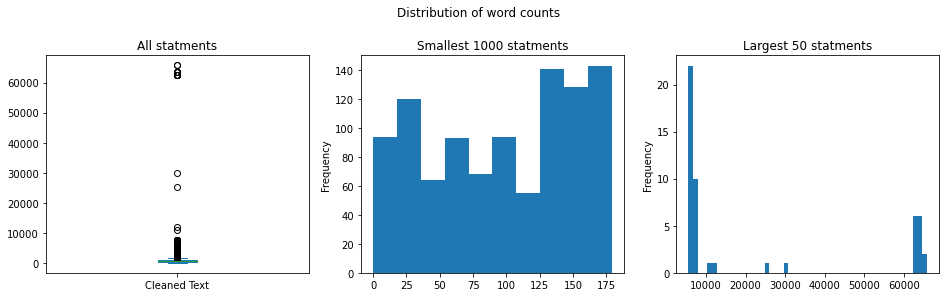

In [35]:
word_counts = statement_df["Cleaned Text"].apply(
    lambda x: len(x.split()) if x is not None and isinstance(x, str) else 0)
word_counts.sort_values(inplace=True)

smallest = 1000
largest = 50
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
plt.suptitle("Distribution of word counts", x=.5, y=1.05)
word_counts.plot.box(ax=ax1)
ax1.set_title(f"All statments")

word_counts.iloc[:smallest].plot.hist(ax=ax2)
ax2.set_title(f"Smallest {smallest} statments")

word_counts.iloc[-largest:].plot.hist(ax=ax3, bins=50)
ax3.set_title(f"Largest {largest} statments")

plt.show()

In [37]:
min_words = 100
max_words = 10000
print(f"Number of statements with word count <= {min_words}: {len(word_counts[word_counts<=min_words])}")
print(f"Number of statements with word count > {max_words}: {len(word_counts[word_counts>max_words])}")

Number of statements with word count <= 100: 502
Number of statements with word count > 10000: 18


In [48]:
statement_df["Cleaned Text"] = statement_df["Cleaned Text"].apply(lambda x: x if x else "#NA")
statement_df["Cleaned Text"] = statement_df["Cleaned Text"].apply(lambda x: x if smallest <= len(x.split()) < largest else "#NA")

In [49]:
(statement_df["Cleaned Text"]=="#NA").sum()

17268

In [ ]:
statement_df["Cleaned Text"] = statement_df["Cleaned Text"].apply(lambda x: x if min_words <= len(x.split()) < max_words else None) 

In [155]:
 len(statement_df["Cleaned Text"].loc[x.iloc[-largest-1:-largest].index[0]].split()), statement_df["Text"].loc[x.iloc[-largest-1:-largest].index[0]]

(5520,
 'Modern Slavery Act Statement 2018/2019\nWm Morrison Supermarkets PLC\nThis statement is made pursuant to section 54 of the Modern Slavery Act 2015 and covers our financial year to 03/02/2019. It details the steps that Morrisons has taken to tackle modern slavery and human trafficking\nwithin our group businesses and supply chains.\nModern slavery, forced labour, human trafficking and exploitation impact workers across all aspects of our global supply chain and represent an unacceptable affront to human rights. At Morrisons, we are guided by our core purpose to make and provide food we’re all proud of, where everyone’s efforts are worthwhile so more and more people can afford to enjoy eating well. Respecting the human rights of everyone involved in the sourcing, manufacture and supply of our products is key to this commitment and our customers rightly expect us to take this responsibility seriously.\nWe are committed to playing an active role in tackling these issues and over t

In [ ]:
subset_data = data[data["final_statement_cleaned"]!="#NA"][["URL", "final_statement_cleaned"]].copy()
subset_data.drop_duplicates(subset="URL", inplace=True)
subset_data.head(6)

,URL,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...
14,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...


# Lemmatizing

In [ ]:
lemmatizer = WordNetLemmatizer() # wordnet lemmatizer object
cleaned_statements = []
for statement in tqdm(subset_data["final_statement_cleaned"], position=0, leave=True):
    cleaned_statements.append(
        " ".join(
            lemmatizer.lemmatize(word, pos="v") for word in statement.split()))

100%|███████████████████████████████████████████████████████████████████████████| 11967/11967 [00:43<00:00, 275.04it/s]


In [ ]:
word_sizes = {}
vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1
        if size not in word_sizes:
            word_sizes[size] = 1
        else:
            word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:06<00:00, 1733.49it/s]


In [ ]:
word_sizes = sort_dict(word_sizes, by=0)

In [218]:
print(f"Total vocab size: {len(vocab)}, total distinct word sizes: {len(word_sizes)}")

Total vocab size: 54691, total distinct word sizes: 85


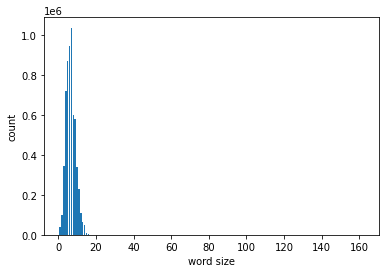

In [219]:
fig, ax = plt.subplots()
ax.bar(word_sizes.keys(), word_sizes.values())
ax.set_xlabel("word size")
ax.set_ylabel("count")
plt.show()

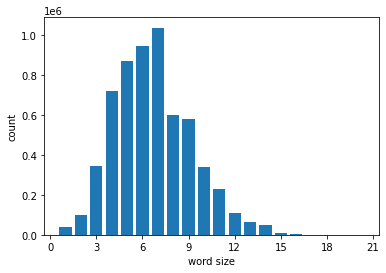

In [220]:
fig, ax = plt.subplots()
ax.bar(list(word_sizes.keys())[:20], list(word_sizes.values())[:20])
ax.set_xlabel("word size")
ax.set_ylabel("count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From above plot, it seems like max word size can be restricted to 15 and min word size to 2

In [221]:
MIN_WORD_SIZE = 2
MAX_WORD_SIZE = 15

In [222]:
temp_cleaned_statements = []
for statement in tqdm(cleaned_statements, position=0, leave=True):
    temp_cleaned_statements.append(
        " ".join([word for word in statement.split() 
                  if MIN_WORD_SIZE <= len(word) <= MAX_WORD_SIZE]))
cleaned_statements = deepcopy(temp_cleaned_statements)

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:02<00:00, 5634.17it/s]


In [223]:
sub_word_sizes = {}
sub_vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in sub_vocab:
            sub_vocab[word] = 1
        else:
            sub_vocab[word] += 1
        if size not in sub_word_sizes:
            sub_word_sizes[size] = 1
        else:
            sub_word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:06<00:00, 1777.10it/s]


In [224]:
sub_word_sizes = sort_dict(sub_word_sizes, by=0)
sub_vocab = sort_dict(sub_vocab, by=1, reverse=True)

In [225]:
print(f"Total vocab size: {len(sub_vocab)}, total distinct word sizes: {len(sub_word_sizes)}")

Total vocab size: 52443, total distinct word sizes: 14


In [229]:
subset_data["final_statement_cleaned_2"] = cleaned_statements

In [230]:
subset_data.head()

,URL,final_statement_cleaned,final_statement_cleaned_2
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...,holdinc europe ltd modern slavery act transpar...
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...,independent research edison investments modern...
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...,slavery human traffic statement slavery human ...
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...,modern slavery atement modern slavery atement ...
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...,modern slavery act slavery human traffic state...


# Generating similarity score between statements

In [231]:
N_GRAM = (1, 1)
count_vect = CountVectorizer(ngram_range=N_GRAM)
X = count_vect.fit_transform(subset_data["final_statement_cleaned_2"])

In [232]:
print(f"Count vector shape: {X.shape}")

Count vector shape: (11967, 52443)


In [233]:
similarity_matrix = cosine_similarity(X, X)

# Tagging almost duplicate statements using similarity score

In [240]:
DUPLICATE_SIMILARITY_SCORE_THRESHOLD = .99
n = X.shape[0]
dup_mapping = {} 
dup_idxs = []
for idx in tqdm(range(n), position=0, leave=True):
    if idx not in dup_idxs:
        idxs = np.argwhere(similarity_matrix[idx][idx+1:] > DUPLICATE_SIMILARITY_SCORE_THRESHOLD).ravel()
        if len(idxs) > 0:
            idxs += idx+1 # shifting
            dup_mapping[idx] = idxs
            dup_idxs += list(idxs)

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:02<00:00, 4468.60it/s]


In [268]:
print(f"Found {len(dup_idxs)} out of {len(subset_data)} with {DUPLICATE_SIMILARITY_SCORE_THRESHOLD*100}% duplicacy")

Found 1191 out of 11967 with 99.0% duplicacy


In [253]:
subset_data[f"{DUPLICATE_SIMILARITY_SCORE_THRESHOLD}%dup"] = [True if idx in dup_idxs else False for idx in tqdm(range(n))]

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:04<00:00, 2888.48it/s]


In [255]:
subset_data.head()

,URL,final_statement_cleaned,final_statement_cleaned_2,0.99%dup
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...,holdinc europe ltd modern slavery act transpar...,False
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...,independent research edison investments modern...,False
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...,slavery human traffic statement slavery human ...,False
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...,modern slavery atement modern slavery atement ...,False
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...,modern slavery act slavery human traffic state...,False


In [256]:
subset_data.to_excel(f"{SHEETS_PATH}\\subset_data.xlsx", index=False)

In [265]:
list(dup_mapping.items())[2]

(50, array([51], dtype=int64))

In [266]:
subset_data["final_statement_cleaned_2"].iloc[50][:100]

'document op issue date revision modern slavery human traffic policy introduction accordance modern s'

In [267]:
subset_data["final_statement_cleaned_2"].iloc[51][:100]

'document op issue date revision modern slavery human traffic policy introduction accordance modern s'

In [249]:
subset_data["URL"].iloc[50], subset_data["URL"].iloc[51]

('https://www.ajnsteelstock.co.uk/wp-content/uploads/2019/04/OP008-Modern-Slavery-and-Human-Trafficking-Policy-Reviewed-04.04.2019.pdf',
 'https://www.ajnsteelstock.co.uk/wp-content/uploads/2016/11/OP008-Modern-Slavery-and-Human-Trafficking-Policy.pdf')

In [207]:
data = pd.read_excel(f"{SHEETS_PATH}\\combined_modern_slavery_statements.xlsx")
data.fillna("#NA", inplace=True)
data["duplicate_statement"] = data.duplicated(subset="URL")

In [208]:
data.head(3)

,Company ID,Company,Statement ID,URL,statement(Edgar),statement(Nitin),final_statement,final_statement(E/N),final_statement_cleaned,duplicate_statement
0,7676,"""K"" Line Holding Europe Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 \u201cK\u201d Line Holding (Europe) Limi...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...,False
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 \u201cK\u201d Line Holding (Europe) Limi...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...,True
2,28659,"""K"" Line (Europe) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 \u201cK\u201d Line Holding (Europe) Limi...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...,True


In [209]:
print("Before cleaning")
print(f"Total non-NA final_statements: {np.sum((data['final_statement_cleaned'] != '#NA'))}")

print("Number of non-NA final_statements(E): "
      f"{np.sum((data['final_statement_cleaned'] != '#NA') & (data['final_statement(E/N)'] == 'E'))}")

print("Number of non-NA final_statements(N): "
      f"{np.sum((data['final_statement_cleaned'] != '#NA') & (data['final_statement(E/N)'] == 'N'))}")

Before cleaning
Total non-NA final_statements: 20699
Number of non-NA final_statements(E): 18619
Number of non-NA final_statements(N): 2080


In [210]:
print("Number of non-NA unique statements : "
      f"{np.sum((data['final_statement_cleaned']!='#NA') & (data['duplicate_statement']==False))}")

print("Number of non-NA duplicate statements : "
      f"{np.sum((data['final_statement_cleaned']!='#NA') & (data['duplicate_statement']==True))}")

Number of non-NA unique statements : 11967
Number of non-NA duplicate statements : 8732


# Selecting unique statements

In [211]:
subset_data = data[data["final_statement_cleaned"]!="#NA"][["URL", "final_statement_cleaned"]].copy()
subset_data.drop_duplicates(subset="URL", inplace=True)
subset_data.head(6)

,URL,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...
14,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...


# Lemmatizing

In [215]:
lemmatizer = WordNetLemmatizer() # wordnet lemmatizer object
cleaned_statements = []
for statement in tqdm(subset_data["final_statement_cleaned"], position=0, leave=True):
    cleaned_statements.append(
        " ".join(
            lemmatizer.lemmatize(word, pos="v") for word in statement.split()))

100%|███████████████████████████████████████████████████████████████████████████| 11967/11967 [00:43<00:00, 275.04it/s]


In [216]:
word_sizes = {}
vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1
        if size not in word_sizes:
            word_sizes[size] = 1
        else:
            word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:06<00:00, 1733.49it/s]


In [217]:
word_sizes = sort_dict(word_sizes, by=0)

In [218]:
print(f"Total vocab size: {len(vocab)}, total distinct word sizes: {len(word_sizes)}")

Total vocab size: 54691, total distinct word sizes: 85


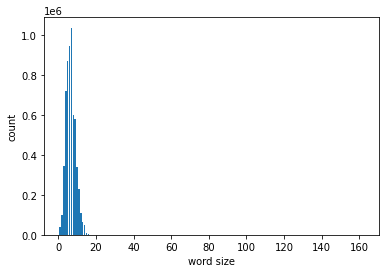

In [219]:
fig, ax = plt.subplots()
ax.bar(word_sizes.keys(), word_sizes.values())
ax.set_xlabel("word size")
ax.set_ylabel("count")
plt.show()

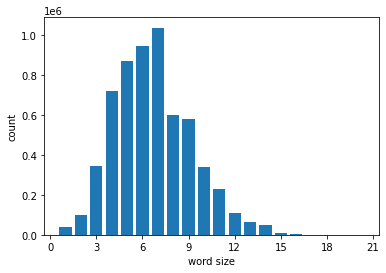

In [220]:
fig, ax = plt.subplots()
ax.bar(list(word_sizes.keys())[:20], list(word_sizes.values())[:20])
ax.set_xlabel("word size")
ax.set_ylabel("count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From above plot, it seems like max word size can be restricted to 15 and min word size to 2

In [221]:
MIN_WORD_SIZE = 2
MAX_WORD_SIZE = 15

In [222]:
temp_cleaned_statements = []
for statement in tqdm(cleaned_statements, position=0, leave=True):
    temp_cleaned_statements.append(
        " ".join([word for word in statement.split() 
                  if MIN_WORD_SIZE <= len(word) <= MAX_WORD_SIZE]))
cleaned_statements = deepcopy(temp_cleaned_statements)

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:02<00:00, 5634.17it/s]


In [223]:
sub_word_sizes = {}
sub_vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in sub_vocab:
            sub_vocab[word] = 1
        else:
            sub_vocab[word] += 1
        if size not in sub_word_sizes:
            sub_word_sizes[size] = 1
        else:
            sub_word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:06<00:00, 1777.10it/s]


In [224]:
sub_word_sizes = sort_dict(sub_word_sizes, by=0)
sub_vocab = sort_dict(sub_vocab, by=1, reverse=True)

In [225]:
print(f"Total vocab size: {len(sub_vocab)}, total distinct word sizes: {len(sub_word_sizes)}")

Total vocab size: 52443, total distinct word sizes: 14


In [229]:
subset_data["final_statement_cleaned_2"] = cleaned_statements

In [230]:
subset_data.head()

,URL,final_statement_cleaned,final_statement_cleaned_2
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...,holdinc europe ltd modern slavery act transpar...
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...,independent research edison investments modern...
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...,slavery human traffic statement slavery human ...
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...,modern slavery atement modern slavery atement ...
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...,modern slavery act slavery human traffic state...


# Generating similarity score between statements

In [231]:
N_GRAM = (1, 1)
count_vect = CountVectorizer(ngram_range=N_GRAM)
X = count_vect.fit_transform(subset_data["final_statement_cleaned_2"])

In [232]:
print(f"Count vector shape: {X.shape}")

Count vector shape: (11967, 52443)


In [233]:
similarity_matrix = cosine_similarity(X, X)

# Tagging almost duplicate statements using similarity score

In [240]:
DUPLICATE_SIMILARITY_SCORE_THRESHOLD = .99
n = X.shape[0]
dup_mapping = {} 
dup_idxs = []
for idx in tqdm(range(n), position=0, leave=True):
    if idx not in dup_idxs:
        idxs = np.argwhere(similarity_matrix[idx][idx+1:] > DUPLICATE_SIMILARITY_SCORE_THRESHOLD).ravel()
        if len(idxs) > 0:
            idxs += idx+1 # shifting
            dup_mapping[idx] = idxs
            dup_idxs += list(idxs)

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:02<00:00, 4468.60it/s]


In [268]:
print(f"Found {len(dup_idxs)} out of {len(subset_data)} with {DUPLICATE_SIMILARITY_SCORE_THRESHOLD*100}% duplicacy")

Found 1191 out of 11967 with 99.0% duplicacy


In [253]:
subset_data[f"{DUPLICATE_SIMILARITY_SCORE_THRESHOLD}%dup"] = [True if idx in dup_idxs else False for idx in tqdm(range(n))]

100%|██████████████████████████████████████████████████████████████████████████| 11967/11967 [00:04<00:00, 2888.48it/s]


In [255]:
subset_data.head()

,URL,final_statement_cleaned,final_statement_cleaned_2,0.99%dup
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,holdinc europe ltd modern slavery act transpar...,holdinc europe ltd modern slavery act transpar...,False
10,https://1spatial.com/who-we-are/legal/modern-s...,independent research edison investments modern...,independent research edison investments modern...,False
11,https://www.shazans.com/slavery-and-human-traf...,slavery human trafficking statement slavery hu...,slavery human traffic statement slavery human ...,False
12,https://www.business-humanrights.org/sites/def...,modern slavery atement modern slavery atement ...,modern slavery atement modern slavery atement ...,False
13,https://www.2agriculture.com/wp-content/upload...,modern slavery act slavery human trafficking s...,modern slavery act slavery human traffic state...,False


In [256]:
subset_data.to_excel(f"{SHEETS_PATH}\\subset_data.xlsx", index=False)

In [265]:
list(dup_mapping.items())[2]

(50, array([51], dtype=int64))

In [266]:
subset_data["final_statement_cleaned_2"].iloc[50][:100]

'document op issue date revision modern slavery human traffic policy introduction accordance modern s'

In [267]:
subset_data["final_statement_cleaned_2"].iloc[51][:100]

'document op issue date revision modern slavery human traffic policy introduction accordance modern s'

In [249]:
subset_data["URL"].iloc[50], subset_data["URL"].iloc[51]

('https://www.ajnsteelstock.co.uk/wp-content/uploads/2019/04/OP008-Modern-Slavery-and-Human-Trafficking-Policy-Reviewed-04.04.2019.pdf',
 'https://www.ajnsteelstock.co.uk/wp-content/uploads/2016/11/OP008-Modern-Slavery-and-Human-Trafficking-Policy.pdf')